### Why is RNA important?

Many of us recognize RNA as the intermediary between DNA and proteins, following the **Central Dogma of Life**—the flow of genetic information from **DNA → RNA → Protein**.

However, RNA is far more than just a messenger. It plays diverse and essential roles in biological systems, from **transporting amino acids for protein synthesis** (tRNA) to **regulating gene expression** (miRNA) and even **catalyzing biochemical reactions** (ribozymes).

**[Import: RNA Types image]**
![RNA Types](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/rna_types.png)

What makes RNA even more fascinating is its potential as the earliest biomolecule of life. Unlike DNA, RNA can both store genetic information and catalyze its own replication, supporting the **RNA World Hypothesis**—the idea that life may have originated with self-replicating RNA molecules.

The critical functional roles of RNAs make them a new type of **drug target**. Since many biological functions depend on the specifc tertiary structures of RNAs, it is imperative to determine the 3D structures of RNAs in order to facilitate RNA-based function annotation and drug discovery.

### ↓ Imports


----- Font -----

[Success] downloaded: carbon-plus.zip
[Success] extracted.
[Error] Failed to load the font. Check the address.

----- Color -----



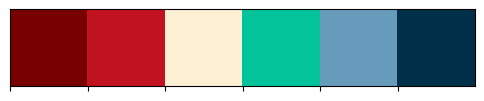

In [1]:
import os
import re
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.signal import resample
from Bio import PDB, SeqIO
from Bio.PDB import MMCIFParser
from io import StringIO
import RNA
import py3Dmol
import forgi.graph.bulge_graph as fgb
import forgi.visual.mplotlib as fvm
from collections import Counter
from tqdm import tqdm
from joblib import Parallel, delayed
from IPython.display import display_html, display
import ipywidgets as widgets
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

class clr:
    B = '\033[1m'
    S = '\033[1m' + '\033[94m'
    L = '\033[1m' + '\033[91m'
    E = '\033[0m'

print(clr.B+'\n----- Font -----\n'+clr.E)
font_url = 'https://ifonts.xyz/core/ifonts-files/downloads/472336/carbon-plus-font.zip'
output_path = 'carbon-plus.zip'

response = requests.get(font_url, stream=True)

if response.status_code == 200:
    with open(output_path, 'wb') as f:
        for chunk in response.iter_content(1024):
            f.write(chunk)
    print(f'[Success] downloaded: {output_path}')
else:
    print('[Error] Failed to download the font. Check the URL.')

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('carbon_plus_font')
    print('[Success] extracted.')

font_path = '/kaggle/working/carbon_plus_font/carbonplus-regular-bl.otf'
try:
    fm.fontManager.addfont(font_path)
    primary_font = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = [primary_font, "DejaVu Sans"]
    print('[Success] loaded.')
except:
    print('[Error] Failed to load the font. Check the address.')

colors = ['#780000', '#c1121f', '#fdf0d5', '#02c39a', '#669bbc', '#003049']
nucleotides = ['X', 'C', 'U', 'G', 'A', '-']
nt_clr = {nt: colors[idx] for idx, nt in enumerate(nucleotides)}
print(clr.B+'\n----- Color -----\n'+clr.E)
sns.palplot(sns.color_palette(colors))

### ↓ Helpers

In [2]:
def interactive_subplot(plot_func, dfs_dict):
    output = widgets.Output()

    def on_select(change):
        with output:
            output.clear_output(wait=True)
            plot_func(dfs_dict[change.new], change.new)
            plt.show()
    
    dropdown = widgets.Dropdown(
        options=dfs_dict.keys(),
        description='Dataset:',
        style={'description_width': 'initial'}
    )
    
    dropdown.observe(on_select, names='value')
    display(dropdown, output)
    
    first_key = next(iter(dfs_dict.keys()), None)
    if first_key:
        with output:
            plot_func(dfs_dict[first_key], first_key)
            plt.show()

def parallel_apply(series, func, desc, n_jobs=-1):
    """Parallel apply with tqdm."""
    results = Parallel(n_jobs=n_jobs)(
        delayed(func)(x) for x in tqdm(series, desc=desc)
    )
    return results

# Loading Data

In [4]:
class Config():
    def __init__(self):
        self.PATH = 'data/kaggle_2025'
        self.CIF_PATH = 'data/kaggle_2025_pdb_dataset_small'

config = Config()
os.makedirs('Figures', exist_ok=True)

In [5]:
def load_data():
    
    train_seq = pd.read_csv(os.path.join(config.PATH, 'train_sequences.csv'))
    valid_seq = pd.read_csv(os.path.join(config.PATH, 'validation_sequences.csv'))
    test_seq = pd.read_csv(os.path.join(config.PATH, 'test_sequences.csv'))

    train_labels = pd.read_csv(os.path.join(config.PATH, 'train_labels.csv'))
    valid_labels = pd.read_csv(os.path.join(config.PATH, 'validation_labels.csv'))

    return train_seq, valid_seq, test_seq, train_labels, valid_labels

def summarize(df, desc='Summary'):

    start = clr.S if 'Sequence' in desc else clr.L
    
    print(start+f'\n----- {desc} -----\n'+clr.E)
    print(f'Shape: {df.shape}')
    print(f'Missing: {df.isna().sum().sum()}')
    print(f'Columns: {df.columns.to_list()}\n')
    display_html(df.head(3))
    print('\n')

In [6]:
train_seq, valid_seq, test_seq, train_labels, valid_labels = load_data()

for df, desc in zip([train_seq, valid_seq, test_seq, train_labels, valid_labels],
                    ['Train Sequence', 'Validation Sequence','Test Sequence',
                     'Train Label', 'Validation Label']):
    summarize(df, desc)


----- Train Sequence -----

Shape: (844, 5)
Missing: 5
Columns: ['target_id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']



,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...





----- Validation Sequence -----

Shape: (12, 5)
Missing: 0
Columns: ['target_id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']



,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."





----- Test Sequence -----

Shape: (12, 5)
Missing: 0
Columns: ['target_id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']



,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."





----- Train Label -----

Shape: (137095, 6)
Missing: 18435
Columns: ['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1']



,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878





----- Validation Label -----

Shape: (2515, 123)
Missing: 0
Columns: ['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5', 'x_6', 'y_6', 'z_6', 'x_7', 'y_7', 'z_7', 'x_8', 'y_8', 'z_8', 'x_9', 'y_9', 'z_9', 'x_10', 'y_10', 'z_10', 'x_11', 'y_11', 'z_11', 'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15', 'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19', 'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23', 'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27', 'x_28', 'y_28', 'z_28', 'x_29', 'y_29', 'z_29', 'x_30', 'y_30', 'z_30', 'x_31', 'y_31', 'z_31', 'x_32', 'y_32', 'z_32', 'x_33', 'y_33', 'z_33', 'x_34', 'y_34', 'z_34', 'x_35', 'y_35', 'z_35', 'x_36', 'y_36', 'z_36', 'x_37', 'y_37', 'z_37', 'x_38', 'y_38', 'z_38', 'x_39', 'y_39', 

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_37,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40
0,R1107_1,G,1,-5.499,8.520,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
1,R1107_2,G,2,-5.826,10.453,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
2,R1107_3,G,3,-5.849,14.768,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18


# Primary Structure

Nucleic acids are macromolecules that exist as polymers called **polynucleotides**. As indicated by the name, each polynucleotide consists of monomers called **nucleotides**. A nucleotide, in general, is composed of three parts: 
+ A five-carbon sugar (a pentose)
+ A nitrogen-containing (nitrogenous) base
+ One to three phosphate groups

To understand the structure of a single nucleotide, let’s first consider the **nitrogenous bases**. Each nitrogenous base has one or two rings that include nitrogen atoms. There are two families of nitrogenous bases: 
+ **Pyrimidines**: A pyrimidine has one six-membered ring of carbon and nitrogen atoms.
    + Cytosine `C`
    + Thymine `T`
    + Uracil `U`
+ **Purines**: Purine is larger, with a six-membered ring fused to a five-membered ring.
    + Adenine `A`
    + Guanine `G`

Adenine, guanine, and cytosine are found in both DNA and RNA; thymine is found only in DNA, and uracil only in RNA. Let's get our hands dirty and explore the dataset a little bit:

In [7]:
print(clr.S+'\n----- Nucleotide components -----\n'+clr.E)
display_html(train_seq.sequence.apply(lambda x: set(x)).value_counts().reset_index())


----- Nucleotide components -----



,sequence,count
0,"{G, A, C, U}",815
1,"{G, A, C}",10
2,"{G, C, U}",6
3,{U},3
4,"{A, U}",2
5,{A},2
6,"{A, -, C, G, U}",2
7,"{A, C, G, U, X}",2
8,"{G, A}",1
9,"{G, C}",1


As you can see, `train_sequences.csv` contain 6 different types of characters based on [FASTA format](https://en.wikipedia.org/wiki/FASTA_format). But the organizers announced for `test_sequences.csv`, this is guaranteed to be a string of `A`, `C`, `G`, and `U`.

| Symbol | Meaning                 |
|--------|-------------------------|
| A      | Adenine                 |
| U      | Uracil                  |
| C      | Cytosine                |
| G      | Guanine                 |
| X      | Any                     |
| -      | Gap or missing base     |

In [8]:
def plot_nucleotide_frequency(df, desc, ax=None):
    nucleotide_counts = Counter(''.join(df['sequence']))
    c = {nt: [count, nt_clr[nt]] for nt, count in nucleotide_counts.items()}
    c = pd.DataFrame(c).T.reset_index().rename(columns={'index': 'nt', 0: 'count', 1: 'color'})

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    sns.barplot(data=c, x='nt', y='count', palette=c.color.to_list(), ax=ax)
    ax.set_title('Nucleotide frequency')
    ax.set_xlabel('')
    if fig:
        plt.savefig(f'Figures/{desc}_plot_nucleotide_frequency.png', dpi=300, bbox_inches='tight')

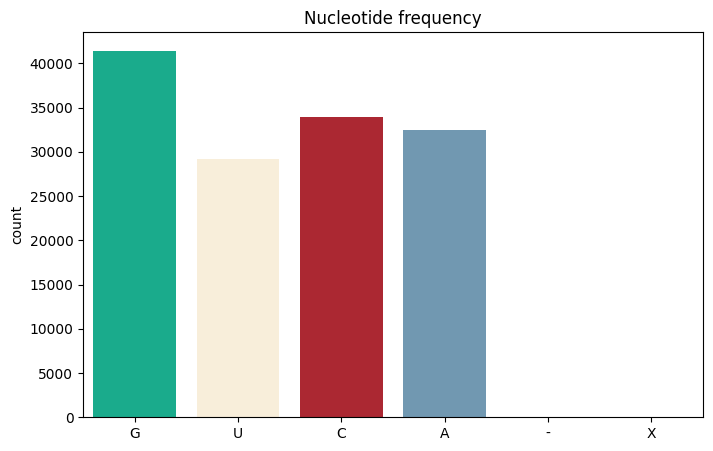

In [9]:
plot_nucleotide_frequency(train_seq, 'Train')

The higher the percent of **G:C base pairs** in the nucleic acids (and hence the lower the content of A:T base pairs), the higher is the melting point. How do we explain this behavior? 

G:C base pairs contribute more to the stability of nucleic acids than do A:T base pairs because of the greater number of hydrogen bonds for the former (three in a G:C base pair vs. two for A:T), but also, importantly, because the stacking interactions of G:C base pairs with adjacent base pairs are more favorable than the corresponding interactions of A:T base pairs with their neighboring base pairs.

In [10]:
def CG_ratio(seq):
    nucleotide_counts = Counter(''.join(seq))
    return (nucleotide_counts['C'] + nucleotide_counts['G']) / len(seq)

def plot_CG_ratio(df, desc, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(df.sequence.apply(CG_ratio), kde=True, ax=ax, color=colors[-1])
    ax.set_title('C+G Ratio frequency')
    ax.set_xlabel('C+G Ratio')
    ax.set_xlim(0, 1)
    if fig:
        plt.savefig(f'Figures/{desc}_plot_CG_ratio.png', dpi=300, bbox_inches='tight')

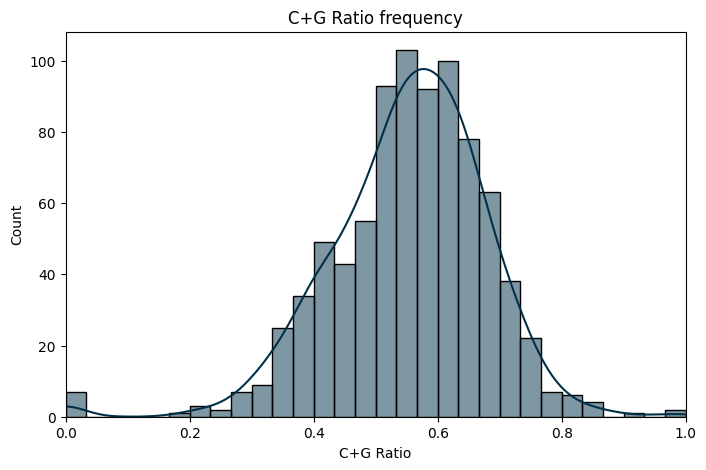

In [11]:
plot_CG_ratio(train_seq, 'Train')

Now let’s add the sugar to which the nitrogenous base is attached. In DNA the sugar is **deoxyribose**; in RNA it is **ribose**. The only difference between these two sugars is that deoxyribose lacks an oxygen atom on the second carbon in the ring, hence the name deoxyribose.

So far, we have built a nucleoside (base plus sugar). To complete the construction of a nucleotide, we attach one to three **phosphate groups** to the 5' carbon of the sugar (the carbon numbers in the sugar include `'`, the prime symbol); With one phosphate, this is a nucleoside monophosphate, more often called a nucleotide.

In [28]:
def plot_backbone(pdb_id):
    
    cif_filename = f"{config.CIF_PATH}/{pdb_id}.cif"
    
    with open(cif_filename, 'r') as file:
        cif_string = file.read()
    
    viewer = py3Dmol.view(width=1000, height=1000)
    viewer.addModel(cif_string, 'cif')
    
    viewer.setStyle({'cartoon': {'colorscheme': 'spectrum'}})
    viewer.setStyle({'atom': ['P']}, {'sphere': {'color': colors[1], 'radius': 0.8}})
    viewer.setStyle({'atom': ["C1'", "C2'", "C3'", "C4'", "O4'"]}, {'stick': {'color': 'spectrum'}})
    
    viewer.zoomTo()
    viewer.show()

In [29]:
# 1AFX - broken??

In [31]:
# Feel free to change the PDB ID
sample_pdb_id = '9ENE'
plot_backbone(sample_pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In this visualiztion, phosphate group and sugar are represented by red sphere and pentagon repectively. Now you might ask, Do we have to predict the location of each atom of the nucleotide? The short answer is **NO**, not in this competition! Here, our goal is to predict the location of each C'1 atom (first-red carbon sugar backbone) of each nucleotide in RNA sequence. 

We will come back to the details of the conformation later in the notebook.

**[Fact]:** I used the mmCIF (.cif) file format, representing each `target_id` of the notebook. You can access the same dataset [Here](https://www.kaggle.com/datasets/amirmmahdavikia/stanford-rna-3d-prediction-pdb-dataset)!

In [32]:
for df, desc in zip([train_seq, valid_seq, test_seq],
                    ['Train Sequence', 'Validation Sequence','Test Sequence']):
    
    df['length'] = df.sequence.apply(lambda x: len(x))
    print(clr.S+f'\n----- {desc} Length -----\n'+clr.E)
    print(f'[MIN]: {df.length.min()}')
    print(f'[MAX]: {df.length.max()}')
    print(f'[AVG]: {df.length.mean():.2f}')
    print(f'[STD]: {df.length.std():.2f}')
    print(f'[Q1]: {df.length.quantile([0.25]).iloc[0]:.2f}')
    print(f'[Q2]: {df.length.quantile([0.5]).iloc[0]:.2f}')
    print(f'[Q3]: {df.length.quantile([0.75]).iloc[0]:.2f}')


----- Train Sequence Length -----

[MIN]: 3
[MAX]: 4298
[AVG]: 162.43
[STD]: 515.03
[Q1]: 22.00
[Q2]: 39.50
[Q3]: 86.00

----- Validation Sequence Length -----

[MIN]: 30
[MAX]: 720
[AVG]: 209.58
[STD]: 194.49
[Q1]: 105.75
[Q2]: 129.50
[Q3]: 269.25

----- Test Sequence Length -----

[MIN]: 30
[MAX]: 720
[AVG]: 209.58
[STD]: 194.49
[Q1]: 105.75
[Q2]: 129.50
[Q3]: 269.25


In [33]:
def plot_length_histogram(df, desc, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(df.length, kde=True, ax=ax, color=colors[-1])
    ax.set_title('Sequence Length Frequency')
    ax.set_xlabel('Length')
    if fig:
        plt.savefig(f'Figures/{desc}_plot_length_histogram.png', dpi=300, bbox_inches='tight')

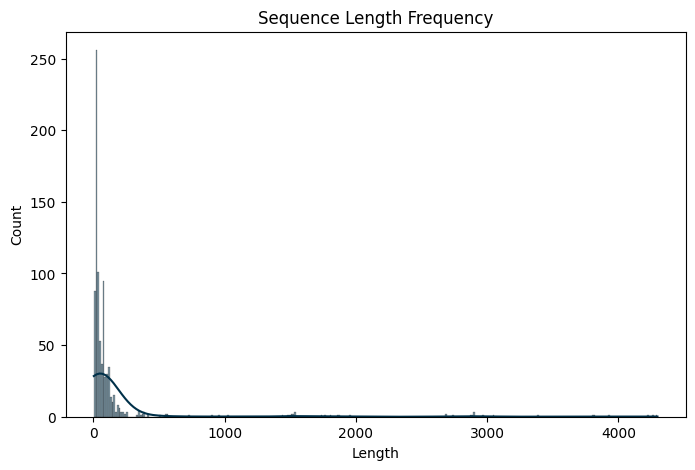

In [34]:
plot_length_histogram(train_seq, 'Train')

# Exploration

In [35]:
for df, desc in zip([train_seq, valid_seq, test_seq],
                    ['Train Sequence', 'Validation Sequence','Test Sequence']):
    
    df['temporal_cutoff'] = pd.to_datetime(df['temporal_cutoff'], errors='coerce')
    print(clr.S+f'\n----- {desc} Cutoff -----\n'+clr.E)
    print(f'[MIN]: {df.temporal_cutoff.min()}')
    print(f'[MAX]: {df.temporal_cutoff.max()}')


----- Train Sequence Cutoff -----

[MIN]: 1995-01-26 00:00:00
[MAX]: 2024-12-18 00:00:00

----- Validation Sequence Cutoff -----

[MIN]: 2022-05-27 00:00:00
[MAX]: 2022-08-11 00:00:00

----- Test Sequence Cutoff -----

[MIN]: 2022-05-27 00:00:00
[MAX]: 2022-08-11 00:00:00


In [36]:
def plot_cutoff_histogram(df, desc, axs=None):
    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    else:
        fig = None

    bars = sns.histplot(df.temporal_cutoff.dt.to_period('Y').astype('str'), kde=True, ax=axs[0], color=colors[-1])
    axs[0].set_title('Temporal Cutoff Frequency')
    axs[0].set_xlabel('Date')
    
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)

    for bar in bars.patches:
        if (bar.get_x() + 1.5) >= 28.0:
            bar.set_facecolor(colors[1])

    valid_cutoff = (df.temporal_cutoff < valid_seq.temporal_cutoff.min()).value_counts().reset_index()
    sizes = valid_cutoff['count'].to_list()
    labels = valid_cutoff['temporal_cutoff'].to_list()
    valid_map = {True: ['Valid', colors[3]], False: ['Invalid', colors[1]]}
    validity = [f'{valid_map[label][0]} ({size})' for size, label in zip(sizes, labels)]
    _colors = [valid_map[label][1] for label in labels]
    axs[1].pie(sizes, labels=validity, colors=_colors)
    axs[1].set_title('Cutoff Validity')

    plt.xticks(rotation=45)

    if fig:
        plt.tight_layout()
        plt.savefig(f'Figures/{desc}_plot_cutoff_histogram.png', dpi=300, bbox_inches='tight')

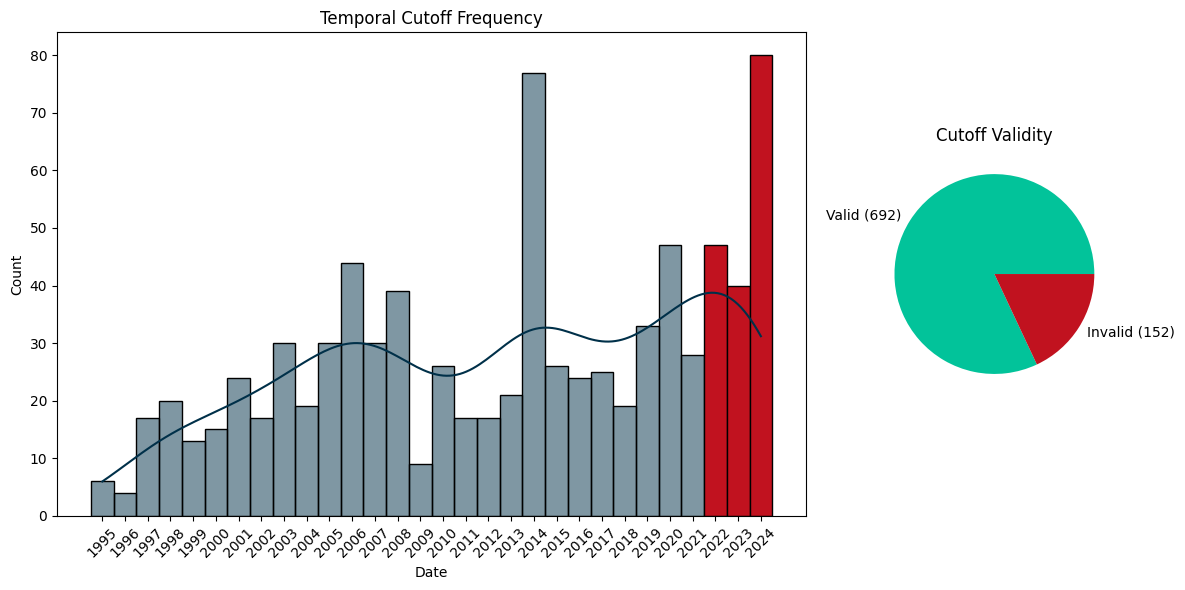

In [37]:
plot_cutoff_histogram(train_seq, 'Train')

In [40]:
for df, desc in zip([train_labels, valid_labels],
                    ['Train Label', 'Validation Label']):
    
    df['chain'] = df.ID.apply(lambda x: x.split('_')[1])
    df['pdb_id'] = df.ID.apply(lambda x: x.split('_')[0])
    df['target_id'] = df.ID.apply(lambda x: re.sub(r'_(\d+)$', '', x))
    missing_count = df.groupby('target_id').x_1.apply(lambda x: x.isna().sum())

    if 'Train' in desc:
        o_missing_count = pd.merge(missing_count.reset_index(), train_seq, on='target_id', how='right')['x_1']
        train_seq['missing_label'] = o_missing_count
        train_seq['missing_ratio'] = train_seq['missing_label'] / train_seq['length']
    else:
        o_missing_count = pd.merge(missing_count.reset_index(), valid_seq, on='target_id', how='right')['x_1']
        valid_seq['missing_label'] = o_missing_count
        valid_seq['missing_ratio'] = valid_seq['missing_label'] / valid_seq['length']

    print(clr.L+f'\n----- {desc} Missing -----\n'+clr.E)
    print(f'[COUNT]: {missing_count[missing_count>0].count()}')
    print(f'[MIN]: {missing_count.min()}')
    print(f'[MAX]: {missing_count.max()}')
    print(f'[AVG]: {missing_count.mean():.2f}')


----- Train Label Missing -----

[COUNT]: 238
[MIN]: 0
[MAX]: 536
[AVG]: 7.28

----- Validation Label Missing -----

[COUNT]: 0
[MIN]: 0
[MAX]: 0
[AVG]: 0.00


In [41]:
def plot_missing_label(df, desc, axs=None):
    
    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 4]})
    else:
        fig = None

    s=df['missing_label'] > 0
    sns.countplot(
        x=s,
        ax=axs[0],
        palette=[colors[4], colors[-1]]
    )
    axs[0].set_title('Any coordinate missing?')
    axs[0].set_xlabel('')
    ticks = axs[0].get_xticks()
    _labels = ['No', 'Yes']
    axs[0].set_xticks(ticks=ticks, labels=_labels[:len(ticks)])
    axs[0].set_ylabel('Count')
    ylim = axs[0].get_ylim()

    sns.histplot(
        df.loc[df.missing_label > 0, 'missing_ratio'], 
        ax=axs[1],
        color=colors[-1],
        kde=True
    )

    axs[1].set_title('Missing Ratio')
    axs[1].set_xlabel('Ratio')
    axs[1].set_ylabel('')
    axs[1].set_ylim(ylim)

    if fig:
        plt.tight_layout()
        plt.savefig(f'Figures/{desc}_plot_missing_label.png', dpi=300, bbox_inches='tight')

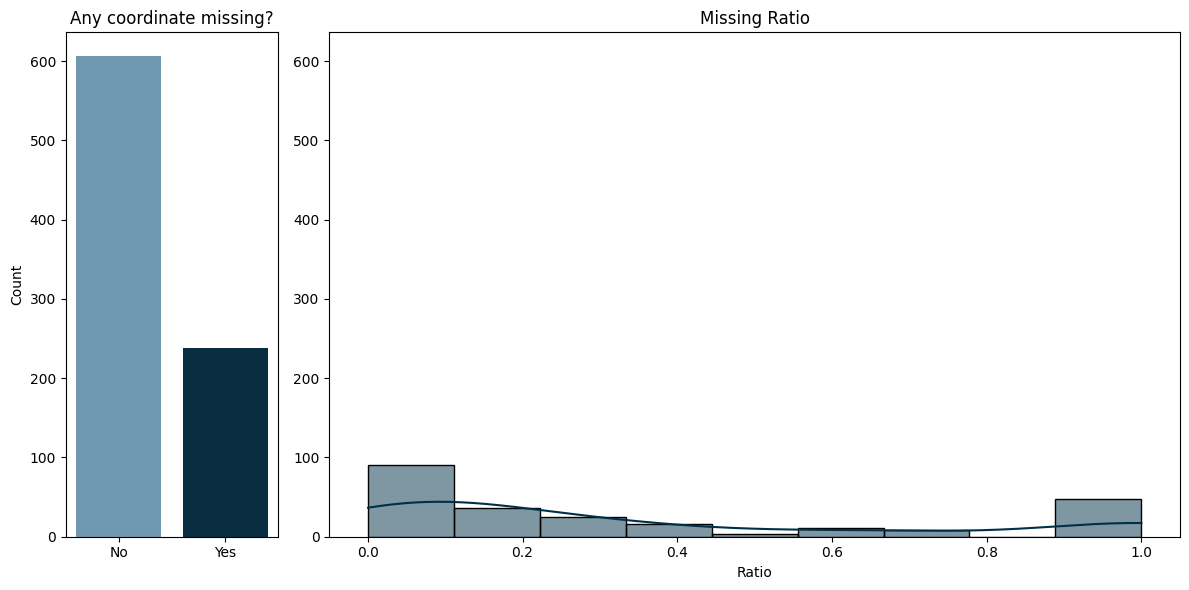

In [42]:
plot_missing_label(train_seq, 'Train')

In [43]:
def resample_array(arr, target_length=1024):
    return np.round(resample(arr, target_length)).astype(int)

def binary_sequence(target_id):
    sequence = train_seq[train_seq.target_id == target_id].sequence
    b_sequence = np.array(train_labels[train_labels.target_id == target_id].x_1.notna().astype(int))
    resampled = resample_array(b_sequence)
    return resampled

def plot_missing_label_pattern(df, desc, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    concat_matrix = []
    selected_df = df.sort_values('missing_label', ascending=False).iloc[:30]
    for idx, rna in selected_df.iterrows():
        b_seq = binary_sequence(rna.target_id)
        concat_matrix.append(b_seq)
    sns.heatmap(np.array(concat_matrix), cmap='viridis', ax=ax, cbar=False)
    ax.set_title('Missing Label Pattern')
    ax.set_yticklabels(labels=selected_df.target_id.to_list())
    ax.xaxis.set_visible(False)
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    if fig:
        plt.savefig(f'Figures/{desc}_plot_missing_label_pattern.png', dpi=300, bbox_inches='tight')

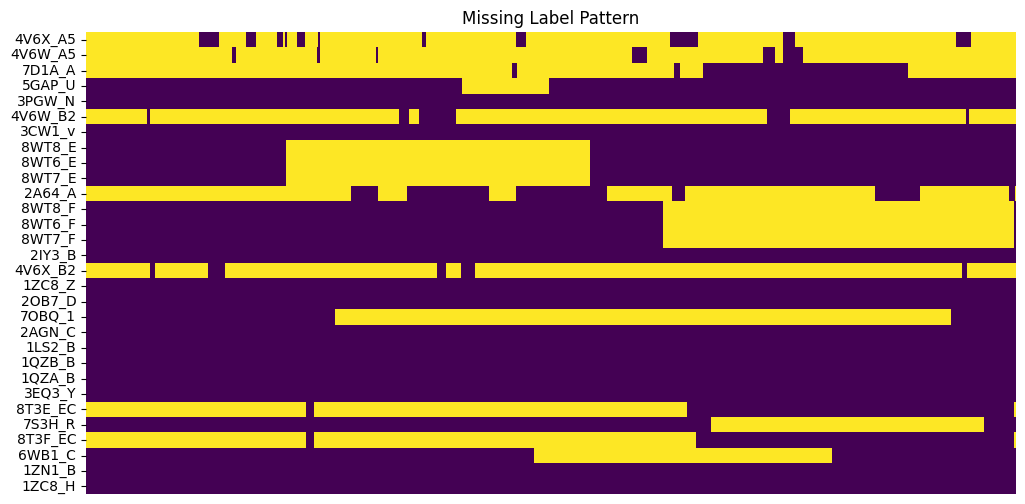

In [44]:
plot_missing_label_pattern(train_seq, 'Train')

### Quick Takeaways:

+ `[Train Dataset]`:
    + 90% of sequences contain fewer than 160 nucleotides.
    + Only 34 sequences exceed 1000 nucleotides.
    + 152 sequences are **invalid for Phase 1 training** due to a temporal cutoff after `2022-05-27`.
    + 238 sequences **lack at least one residue coordinate**.
    + 46 sequences are **missing coordinate labels entirely**.
    + No clear pattern is observed in the missing coordinate labels.

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>Secondary Structure</b></div>

Despite being single-stranded, RNA molecules often exhibit a great deal of **double-helical** character. This is because RNA chains frequently fold back on themselves to form base-paired segments between short stretches of complementary sequences.

![Secondary Structure](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/rna_secondary_structure.png)

If the two stretches of complementary sequence are near each other, the RNA may adopt a **stem-loop structure** in which the intervening RNA is looped out from the end of the double-helical segment. 

Stretches of double-helical RNA may also exhibit **internal loops** (unpaired nucleotides on either side of the stem), **bulges** (anunpaired nucleotide on one side of the bulge), or **junctions**.

### How Can We Predict RNA Secondary Structure?

Ultimately, a true secondary structure can be verifed when the 3D structure is determined. Crystallography, NMR, and now high-resolution cryo-electron microscopy (cryo-EM) represent the _crème de la crème_, with NMR and cryo-EM also having the ability to potentially detect conformational ensembles and dynamics.

![Secondary Structure](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/rna_secondary_structure_prediction.png)

However, for large-scale analysis, computational prediction remains the most practical approach. For now, we will use automatic **thermodynamics-based** algorithm (**RNAfold**, part of the **ViennaRNA**) to predict the secondary structure for each sequence. 

In [45]:
def base_pairing_probability(seq):
    """
    Computes the base pairing probability matrix (BPPM) for a given RNA sequence.
    """
    fc = RNA.fold_compound(seq)
    fc.pf()
    bpp = fc.bpp()
    bppm = np.array([list(bp) for bp in bpp])
    bppm = bppm[1:, 1:]  # Remove 0th dummy row and column
    return bppm

def dot_bracket(seq):
    """
    Predicts the minimum free energy (MFE) secondary structure of an RNA sequence in dot-bracket notation.
    """
    fc = RNA.fold_compound(seq)
    return fc.mfe()

def predict_secondary_structure(df, df_name='dataset'):
    print(clr.S+f"\n--- Dot-Bracket {df_name} ---\n"+clr.E)

    ss_results = parallel_apply(df['sequence'], dot_bracket, desc=f'{df_name} - DB', n_jobs=-1)
    df[['secondary_structure', 'mfe']] = pd.DataFrame(ss_results, index=df.index)

    return df

In [46]:
for df, desc in zip([train_seq, valid_seq, test_seq],
                    ['Train Sequence', 'Validation Sequence','Test Sequence']):
    
    df = predict_secondary_structure(df, desc)


--- Dot-Bracket Train Sequence ---



Train Sequence - DB: 100%|██████████| 844/844 [00:00<00:00, 996.98it/s]



--- Dot-Bracket Validation Sequence ---



Validation Sequence - DB: 100%|██████████| 12/12 [00:00<00:00, 21779.16it/s]



--- Dot-Bracket Test Sequence ---



Test Sequence - DB: 100%|██████████| 12/12 [00:00<00:00, 15665.00it/s]


The **dot-bracket** notation is a simplified way to represent RNA secondary structures, where dots `.` indicate unpaired nucleotides, and matching parentheses `( )` represent base pairs (e.g., ”((…))” for a hairpin loop). 

In [27]:
train_seq[['target_id', 'sequence', 'secondary_structure']].head()

,target_id,sequence,secondary_structure
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,((((((...((.(.....).)).))))))
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,(((((((....)).)))))...............
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,.((((((.((....))))))))..
3,1HLX_A,GGGAUAACUUCGGUUGUCCC,((((((((....))))))))
4,1HMH_E,GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU,..............((((....))))........


It doesn't seem intuitive, right? Let's visualize better:

In [47]:
def plot_dot_bracket(seq, dot_bracket, desc=None, max_length=50):
    fig, ax = plt.subplots(figsize=(4, 4))
    bg = fgb.BulgeGraph.from_dotbracket(dot_bracket, seq)
    fvm.plot_rna(bg, ax=ax, text_kwargs={'fontsize': 6, 'color': 'black'})
    ax.set_title(f'(Potential) Secondary Structure - {desc}')
    if fig:
        plt.savefig(f'Figures/{desc}_plot_dot_bracket.png', dpi=300, bbox_inches='tight')

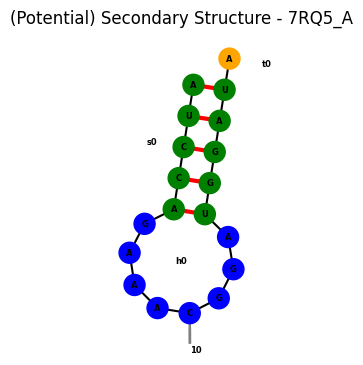

In [48]:
sample_idx = np.random.randint(len(train_seq))
sample_seq = train_seq.sequence.iloc[sample_idx]
sample_target_id = train_seq.target_id.iloc[sample_idx]
sample_dot_bracket = train_seq.secondary_structure.iloc[sample_idx]
plot_dot_bracket(sample_seq, sample_dot_bracket, desc=sample_target_id)

### How can we use it for prediction?

We need better representation, **Base Pair Probability Matrix (BPPM)**. This matrix represents the likelihood of each nucleotide pairing with another in an RNA secondary structure, where each entry $(i, j)$ contains the probability that nucleotide $i$ forms a base pair with nucleotide $j$.

In [54]:
def plot_bppm(seq, dot_bracket, desc=None, max_length=50):
    
    bg = fgb.BulgeGraph.from_dotbracket(dot_bracket, seq)
    if len(seq) > max_length:
        seq = seq[:max_length]
    
    bppm = base_pairing_probability(seq)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    sns.heatmap(bppm, 
                cmap='viridis',
                ax=axs[0],
                annot=False)
    axs[0].set_xlabel('Position in sequence')
    axs[0].set_ylabel('Position in sequence')
    axs[0].set_title(f'Base Pairing Probability Matrix - {desc}')

    
    fvm.plot_rna(bg, ax=axs[1], text_kwargs={'fontsize': 8, 'color': 'black'})
    axs[1].set_title(f'Secondary Structure - {desc}')
    if fig:
        plt.savefig(f'Figures/{desc}_plot_bppm.png', dpi=300, bbox_inches='tight')

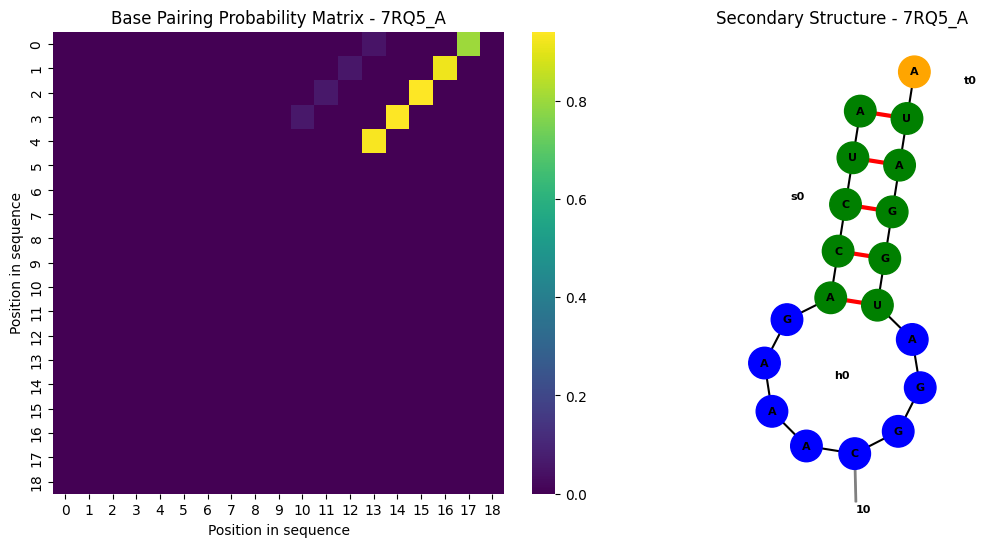

In [55]:
plot_bppm(sample_seq, sample_dot_bracket, desc=sample_target_id)

### Pitfall?

The danger of only considering the lowest free-energy structure and showcasing it as **“The”** secondary structure is the major pitfall here. Thermodynamics-based algorithms consider all nucleotides as equally likely to be involved in secondary structure elements, which often leads to erroneous assumptions about base pairs.

A feature of RNA that adds to its propensity to form double-helical structures is additional **non-Watson-Crick** base pairs. One such example is the G:U base pair. Non-Watson-Crick base pairs can be found in all
combinations in RNA (GA and GU are the most abundant in ribosomal RNA).

![Base Pair Types](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/base_pair_types.png)

Because such non-Watson-Crick base pairs can occur as well as the two conventional Watson-Crick base pairs, RNA chains have an enhanced capacity for self-complementarity.

In [56]:
def plot_mfe_length(df, desc, ax=None):
    sns.jointplot(df, x='mfe', y='length', kind='reg', color=colors[-1])

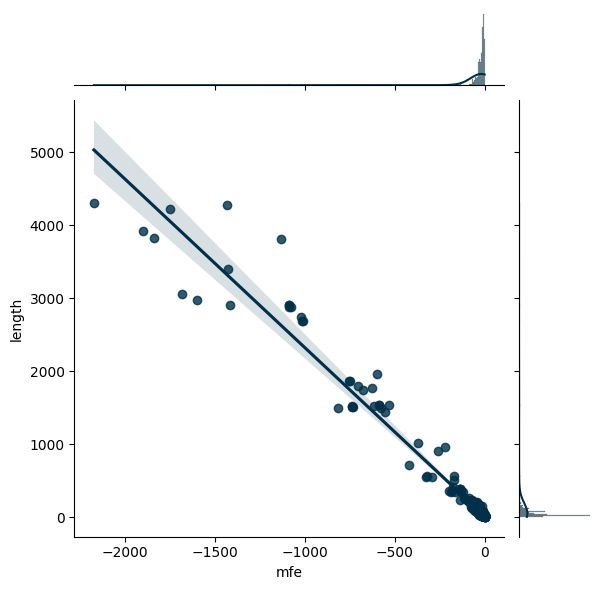

In [57]:
plot_mfe_length(train_seq, 'Train')

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>🎯 Tertiary Structure 🎯</b></div>

In [58]:
def plot_xyz_frequency(df, desc, axs=None):

    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    else:
        fig = None

    sns.histplot(df.x_1.replace(-1.000000e+18, np.nan), kde=True, ax=axs[0], color=colors[-1])
    axs[0].set_title('X coordinate')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Count')
    axs[0].set_xlim([-1000, 1000])
    axs[0].set_ylim([0, 6000])

    sns.histplot(df.y_1.replace(-1.000000e+18, np.nan), kde=True, ax=axs[1], color=colors[-1])
    axs[1].set_title('Y coordinate')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Count')
    axs[1].set_xlim([-1000, 1000])
    axs[1].set_ylim([0, 6000])

    sns.histplot(df.z_1.replace(-1.000000e+18, np.nan), kde=True, ax=axs[2], color=colors[-1])
    axs[2].set_title('Z coordinate')
    axs[2].set_xlabel('')
    axs[2].set_ylabel('Count')
    axs[2].set_xlim([-1000, 1000])
    axs[2].set_ylim([0, 6000])
    
    if fig:
        plt.tight_layout()
        plt.savefig(f'Figures/{desc}_plot_xyz_frequency.png', dpi=300, bbox_inches='tight')

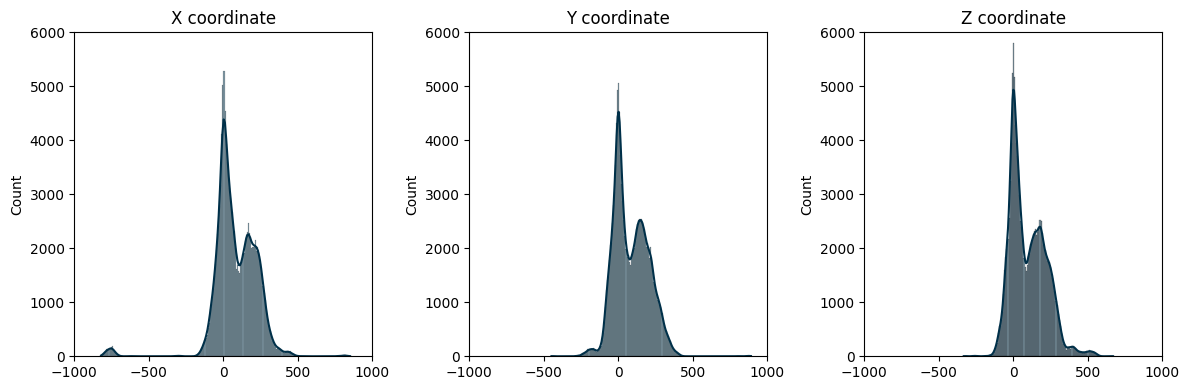

In [59]:
plot_xyz_frequency(train_labels, 'Train')

In [60]:
def plot_3d_strcutrue(pdb_id):
    rna = train_labels[train_labels.pdb_id == pdb_id]
    chains = sorted(set(rna.chain))
    num_chains = len(chains)

    def interpolate_gray(index, total):
        ratio = index / max(total - 1, 1)
        gray_value = int(200 - (150 * ratio))
        return f'rgb({gray_value},{gray_value},{gray_value})'
    
    chain_color_map = {chain: interpolate_gray(i, num_chains) for i, chain in enumerate(chains)}
    
    pdb_data = ""
    for _, residue in rna.iterrows():
        pdb_data += f'ATOM  {residue.resid:5d}  P   {residue.resname} {residue.chain} {residue.resid:4d}    '\
                    f'{residue.x_1:8.3f}{residue.y_1:8.3f}{residue.z_1:8.3f}\n'
    
    view = py3Dmol.view(width=600, height=400)
    view.addModel(pdb_data, 'pdb')
    
    for _, residue in rna.iterrows():
        view.addSphere({
            'center': {'x': residue.x_1, 'y': residue.y_1, 'z': residue.z_1},
            'radius': 1.2,
            'color': nt_clr.get(residue.resname, 'white')
        })
        view.addLabel(f'{residue.resname}{residue.resid}', {
            'position': {'x': residue.x_1, 'y': residue.y_1, 'z': residue.z_1},
            'backgroundColor': chain_color_map[residue.chain],
            'fontColor': 'white',
            'fontSize': 10
        })


    cif_filename = f"{config.CIF_PATH}/{pdb_id}.cif"
    
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure(pdb_id, cif_filename)
    
    output_pdb = StringIO()
    first_model = next(structure.get_models())
    
    for chain in first_model:
        if chain.id in chains:  # Include only relevant chains
            for residue in chain:
                for atom in residue:
                    output_pdb.write(f"ATOM  {atom.serial_number:5d}  {atom.name:<4} {residue.resname} {chain.id} {residue.id[1]:4d}    "
                                     f"{atom.coord[0]:8.3f}{atom.coord[1]:8.3f}{atom.coord[2]:8.3f}\n")
    
    target_pdb_string = output_pdb.getvalue()
    
    view.addModel(target_pdb_string, 'pdb')
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.zoomTo()
    view.show()

In [61]:
plot_3d_strcutrue(sample_pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In this representation, the spheres correspond to XYZ coordinates of C'1 atom from `[]_labels.csv`, while the ribbon depicts the actual 3D structure obtained from the PDB.

# Multiple Sequence Alignment

**Multiple Sequence Alignment (MSA)** is a technique to align structurally similar sequences in order to extract evolutionary information about the sequence structure and potentialy its function. These similarities can reveal evolutionary relationships, conserved functional domains, and structural motifs.

RNAs with similar sequences often fold into similar structures, so aligning homologous sequences helps identify conserved residues and co-evolutionary patterns. These patterns are essential for methods like **AlphaFold** and **RoseTTAFold**.

One can extract MSAs for each sequence of dataset by retrieving the related datasets (NCBI, Rfam, ...) for similar patterns, But here we will use tha kaggle provided MSA dataset:

In [38]:
def msa_count(target_id):
    msa_file = os.path.join(config.PATH, 'MSA', f'{target_id}.MSA.fasta')
    try:
        return sum(1 for _ in SeqIO.parse(msa_file, 'fasta')) - 1
    except FileNotFoundError:
        return np.nan

for df, desc in zip([train_seq, valid_seq, test_seq],
                    ['Train Sequence', 'Validation Sequence','Test Sequence']):
    
    df['msa_count'] = df['target_id'].apply(msa_count)
    df['msa_presence'] = pd.Series(df['msa_count']).gt(0)
    print(clr.S+f'\n----- {desc} MSA -----\n'+clr.E)
    print(f'[HIT]: {df.msa_presence.sum()}')
    print(f'[MIN]: {df.msa_count.min()}')
    print(f'[MAX]: {df.msa_count.max()}')
    print(f'[AVG]: {df.msa_count.mean():.2f}')
    df['msa_presence'] = df['msa_presence'].map({True: 'Hit', False: 'No Hit'})


----- Train Sequence MSA -----

[HIT]: 716
[MIN]: 0
[MAX]: 31533
[AVG]: 2730.07

----- Validation Sequence MSA -----

[HIT]: 11
[MIN]: 0
[MAX]: 3182
[AVG]: 886.83

----- Test Sequence MSA -----

[HIT]: 11
[MIN]: 0
[MAX]: 3182
[AVG]: 886.83


In [39]:
def plot_msa_analytics(df, desc, axs=None):
    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 4]})
    else:
        fig = None

    sns.countplot(
        data=df,
        x='msa_presence',
        ax=axs[0],
        palette=[colors[3], colors[1]]
    )
    axs[0].set_title('MSA Presence')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Count')
    ylim = axs[0].get_ylim()

    sns.histplot(
        df.loc[df.msa_count > 0, 'msa_count'].dropna(), 
        ax=axs[1],
        color=colors[-1]
    )

    axs[1].set_title('Frequency of MSA Hits')
    axs[1].set_xlabel('Hits')
    axs[1].set_ylabel('')
    axs[1].set_ylim(ylim)

    if fig:
        plt.tight_layout()
        plt.savefig(f'Figures/{desc}_plot_msa_analytics.png', dpi=300, bbox_inches='tight')

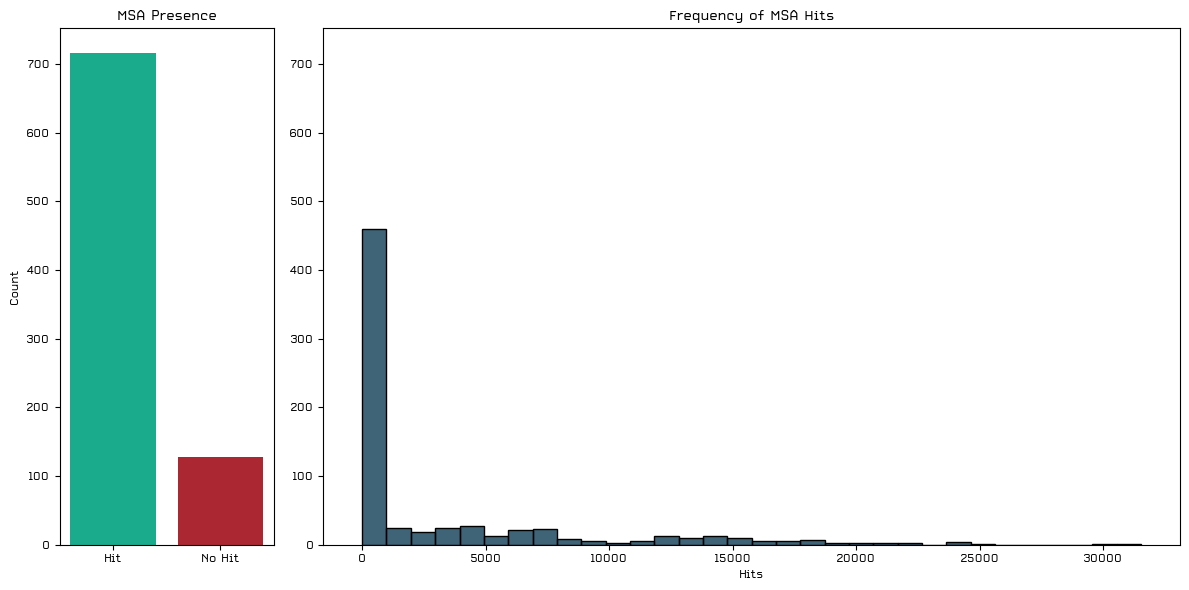

In [40]:
plot_msa_analytics(train_seq, 'Train')

In [41]:
def plot_msa(target_id, max_sequence=20, max_position=40):
    msa_file = os.path.join(config.PATH, 'MSA', f'{target_id}.MSA.fasta')
    
    sequences = []
    try:
        for record in SeqIO.parse(msa_file, 'fasta'):
            sequences.append(list(str(record.seq)))
    except FileNotFoundError:
        print(np.nan)
    
    msa_df = pd.DataFrame(sequences)
    
    present_nucleotides = set(msa_df.values.flatten())
    _nt_clr = {nt: nt_clr[nt] for nt in present_nucleotides}
    nt_to_num = {nt: idx for idx, nt in enumerate(_nt_clr.keys())}
    cmap = ListedColormap([_nt_clr[nt] for nt in _nt_clr.keys()])
    
    msa_numeric = msa_df.replace(nt_to_num)
    if msa_numeric.shape[0] > max_sequence:
        msa_numeric = msa_numeric[:max_sequence]
    if msa_numeric.shape[1] > max_position:
        msa_numeric = msa_numeric[:, :max_position]    

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(msa_numeric, 
                cmap=cmap, 
                cbar=False, 
                xticklabels=False,
                yticklabels=False, 
                ax=ax,
                annot=False)
    
    for i in range(msa_numeric.shape[0]):
        for j in range(msa_numeric.shape[1]):
            nucleotide = msa_df.iloc[i, j]
            ax.text(j + 0.5, i + 0.5, 
                    nucleotide, 
                    ha='center', 
                    va='center', 
                    fontsize=8, 
                    color='black', 
                    fontweight='bold')
    
    _labels = ['Original'] + [str(idx+1) for idx in range(msa_numeric.shape[0]-1)]
    ax.set_yticks(np.arange(msa_numeric.shape[0]) + 0.5)
    ax.set_yticklabels(_labels)
    plt.xlabel('Position in sequence')
    plt.title(f'MSA - {target_id}')

    if fig:
        plt.savefig(f'Figures/{target_id}_plot_msa.png', dpi=300, bbox_inches='tight')
    plt.show()

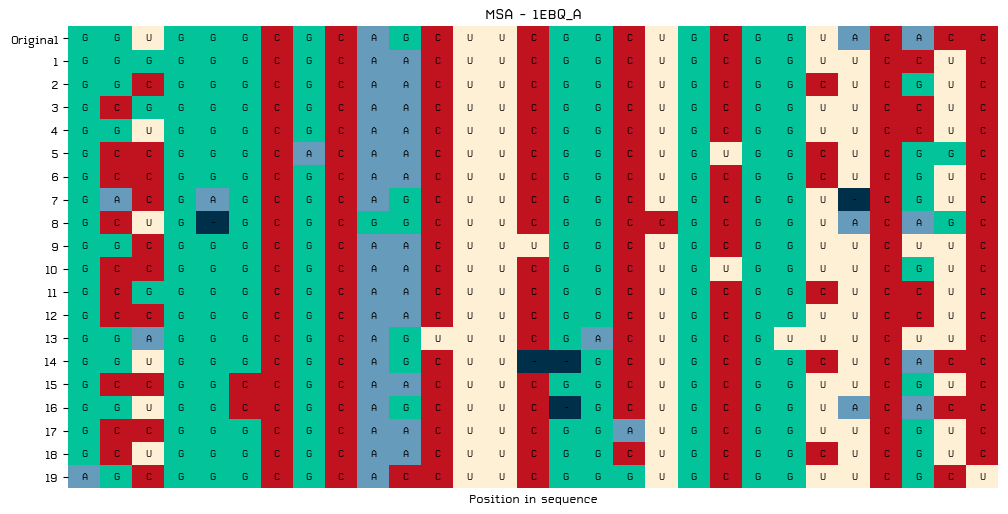

In [42]:
plot_msa(target_id='1EBQ_A') # Feel free to change

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>Baseline</b></div>

### To Be Continued ...

#### ✓ To Do:
+ Pytorch Baseline implementation
+ List Similar Datasets
+ List Current Approaches

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>Summary</b></div>

![Base Pair Types](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/stanford_rna_3d_folding_summary.png)

### Resources

1.	Watson, J. D., Baker, T. A., Bell, S. P., Gann, A., Levine, M., & Losick, R. (2013). Molecular Biology of the Gene (7th ed.). Pearson Education. ISBN: 978-0321762436.
2. Nelson, D. L., & Cox, M. M. (2017). Lehninger Principles of Biochemistry (7th ed.). W.H. Freeman. ISBN: 978-1464126116.
3. Berman, H. M., Westbrook, J., Feng, Z., Gilliland, G., Bhat, T. N., Weissig, H., … & Bourne, P. E. (2000). The Protein Data Bank. Nucleic Acids Research, 28(1), 235-242. DOI: 10.1093/nar/28.1.235.
4. Urry, L. A., Cain, M. L., Wasserman, S. A., Minorsky, P. V., & Reece, J. B. (2020). Campbell Biology (12th ed.). Pearson. ISBN: 978-0135188743.
5. Jumper, J., Evans, R., Pritzel, A., et al. (2021). Highly accurate protein structure prediction with AlphaFold. Nature, 596, 583–589. DOI: 10.1038/s41586-021-03819-2.
6. Weeks, K. M. (2021). Thoughts on how to think (and talk) about RNA structure. Proceedings of the National Academy of Sciences, 118(37), e2112677119. DOI: 10.1073/pnas.2112677119.
7. Wang, W., Feng, C., Han, R., Wang, Z., Ye, L., Du, Z., Wei, H., Zhang, F., Peng, Z., & Yang, J. (2023). trRosettaRNA: automated prediction of RNA 3D structure with transformer network. Nature Communications, 14, 7266. DOI: 10.1038/s41467-023-42528-4.

### <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>🔼 Your Welcome 🔼</b></div>